Эксперименты

## 1. Intro to PyTorch

In [1]:
import numpy as np
import copy
import time
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
from torch.optim import Optimizer

In [3]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [4]:
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

In [5]:
matplotlib.use('Agg')
params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 45,
          "xtick.labelsize": 25,
          "ytick.labelsize": 25,
          "lines.linewidth": 2,
           "axes.titlesize":30}
matplotlib.rcParams.update(params)

## 2. Постановка задачи

Минимизация математического ожидания:

$$f(\mathbf{w}) = \mathbb{E}_\xi F(\mathbf{w}, \xi)\rightarrow \min_{\textbf{w}\in\mathbb{R}^n}$$

Минимизация сумма функций:

$$\frac{1}{M}\sum_{i=1}^M f_i(\textbf{w}) \rightarrow \min_{\textbf{w}\in\mathbb{R}^n},$$
где $f_i$ - гладкие функции.

Примеры:

- максимизация логарифма правдоподобия: $$\ln L(\{\textbf{x}_i\}, \theta) = \sum_{i=1}^M \ln p_\theta(\textbf{x}_i)\rightarrow \max_{\theta}$$

- задачи классификации / регрессии: $$\frac{1}{M}\sum_{i=1}^M f((\textbf{x}_i, \textbf{y}_i), \textbf{w}) \rightarrow \min_{\textbf{w}\in\mathbb{R}^n},$$


In [6]:
def gradf_inexact(w, gradf, Delta=0, dtype=1, v=None):
    n = len(w)
    g = gradf(w)
    xi = np.random.normal(0, 1, (n,))
    if dtype==1:
        xi /= np.linalg.norm(xi)
    elif dtype==2:
        xi /= n
    elif dtype == 3:
        xi = -g.copy()
        xi /= np.linalg.norm(xi)
    elif dtype == 4:
        xi = v / np.linalg.norm(v)
    assert np.linalg.norm(xi)<=1+1e-9, "xi has no 1 norm"
    return g + Delta * xi

In [7]:
class GradientDescent:
    def __init__(self, StepSizeChoice, return_history=True, name=None, save_iter=1):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.history = []
        self.save_iter = save_iter
    
    def __call__(self, x0, f, gradf, N):
        self.history = [(x0, time.time())]
        x = x0.copy()
        for k in range(N):
            h = -gradf(x)
            alpha = self.StepSizeChoice(x, h, k, gradf, f)
            x = x + alpha * h
            if self.return_history:
                self.history.append((x, time.time()))
        return x
    
    def solve(self, x0, f, gradf, tol=1e-3, max_iter=10000):
        self.history = [(x0, time.time())]
        x = x0.copy()
        k = 0
        x_prev = None
        while x_prev is None or np.linalg.norm(gradf(x)) > tol: 
            h = -gradf(x)
            alpha = self.StepSizeChoice(x, h, k, gradf, f)
            x_prev, x = x, x + alpha * h
            if self.return_history and k%self.save_iter==0:
                self.history.append((x, time.time()))
            if k >= max_iter:
                break
            k += 1
        return x

def parse_logs(xhistory, ret_time=False, funcx=None):
    values = [funcx(x) for x, _ in xhistory]
    if ret_time:
        times = [t for _, t in xhistory]
        times = [times[ind]-times[0] for ind, t in enumerate(times)]
    else:
        times = [i for i in range(len(xhistory))]
    return times, np.array(values)

In [8]:
class StepSize:
    def __call__(self, x, h, k, *args, **kwargs):
        pass

class ConstantStepSize(StepSize):
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, x, h, k, *args, **kwargs):
        return self.alpha

## 1. Минимизация логистической регрессии с $\ell_2$ регуляризацией

In [9]:
def f1(w, X, Y, sigma=0):
    Y = (Y-1/2)*2
    logit = -Y * (X@w)
    logit1 = jnp.clip(logit, None, 0)
    logit2 = jnp.clip(logit, 0, None)
    log = jnp.log(jnp.exp(logit1)+1) + logit2
    return (log).sum() / len(Y) + sigma * (w**2).sum()

gradf = jax.grad(f1, argnums=0, has_aux=False)
jit_gradf = jax.jit(gradf)

In [10]:
np.random.seed(1)
n, m = 100, 200
k = 10
X = np.random.randn(n, m)
X = np.vstack([X, X[-k:]])
w = np.random.randn(m)
Y = np.sign(X @ w)
Y[-k:] *= -1
X.shape, Y.shape, w.shape, np.linalg.norm(w)

((110, 200), (110,), (200,), 15.744252812419115)

In [11]:
np.random.seed(1)
n, m = 700, 200
k = 10
W, _ = np.linalg.qr(np.random.randn(m, m))
#W = np.eye(m)
X_base = W[:k]
X_w = np.random.randint(-10, 10, (n-2*k, k))
#X_w = (X_w.T / np.linalg.norm(X_w, 2, 1)).T
X = np.vstack([X_base, X_base, X_w @ X_base])
X = (X - X.mean(0))/X.std()
w = np.random.randn(m)
Y = np.sign(X@w)
Y[:k] *= -1
X.shape, Y.shape

((700, 200), (700,))

In [12]:
np.linalg.matrix_rank(X)

10

In [13]:
A = X
eigvals, _ = np.linalg.eigh(A.T @ A)
L = np.real((eigvals.max()) / 4 / A.shape[0])
L

6.042730110525059

In [14]:
sigma=0
gradf = lambda x: np.array(jit_gradf(x, X, Y, sigma).block_until_ready())
f = lambda x: f1(x, X, Y, sigma)

In [15]:
#w = np.random.randn(X.shape[-1])
f(w).item(), f(np.zeros(m)).item()

(0.06912040951537841, 0.6931471805599454)

### 1.1 Dtype 1

The case when $\xi \sim \mathcal{U}(S_1(0))$

In [16]:
np.random.seed(1)
alpha = 1/L
#alpha = 1e-1
w = np.zeros(X.shape[-1])
Delta_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
#Delta_list = [0]
N = int(1e5)
save_iter = int(1)
tol = 1e-9
methods = []
for Delta in Delta_list:
    tol = np.sqrt(6)*Delta
    grad_inexact = lambda w: gradf_inexact(w, gradf, Delta, 1)
    method = GradientDescent(ConstantStepSize(alpha), name="GD, Delta={}".format(Delta), save_iter=save_iter)
    x = method.solve(w, f, grad_inexact, tol=tol, max_iter=N)
    print(Delta, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history))
    methods.append(method)
#001448072963264384

1e-05 2.382133486307082e-05 0.060685366111537555 4.391575892168115 12653
0.0001 0.0002346426535240581 0.060696830692501695 4.302152146177909 6723
0.001 0.002356582949079295 0.06151511949866747 3.624382733641171 1854
0.01 0.022321803643810798 0.07684298769505245 1.896999502479045 158
0.1 0.1356503825750921 0.12542607652813217 0.897370151598005 4


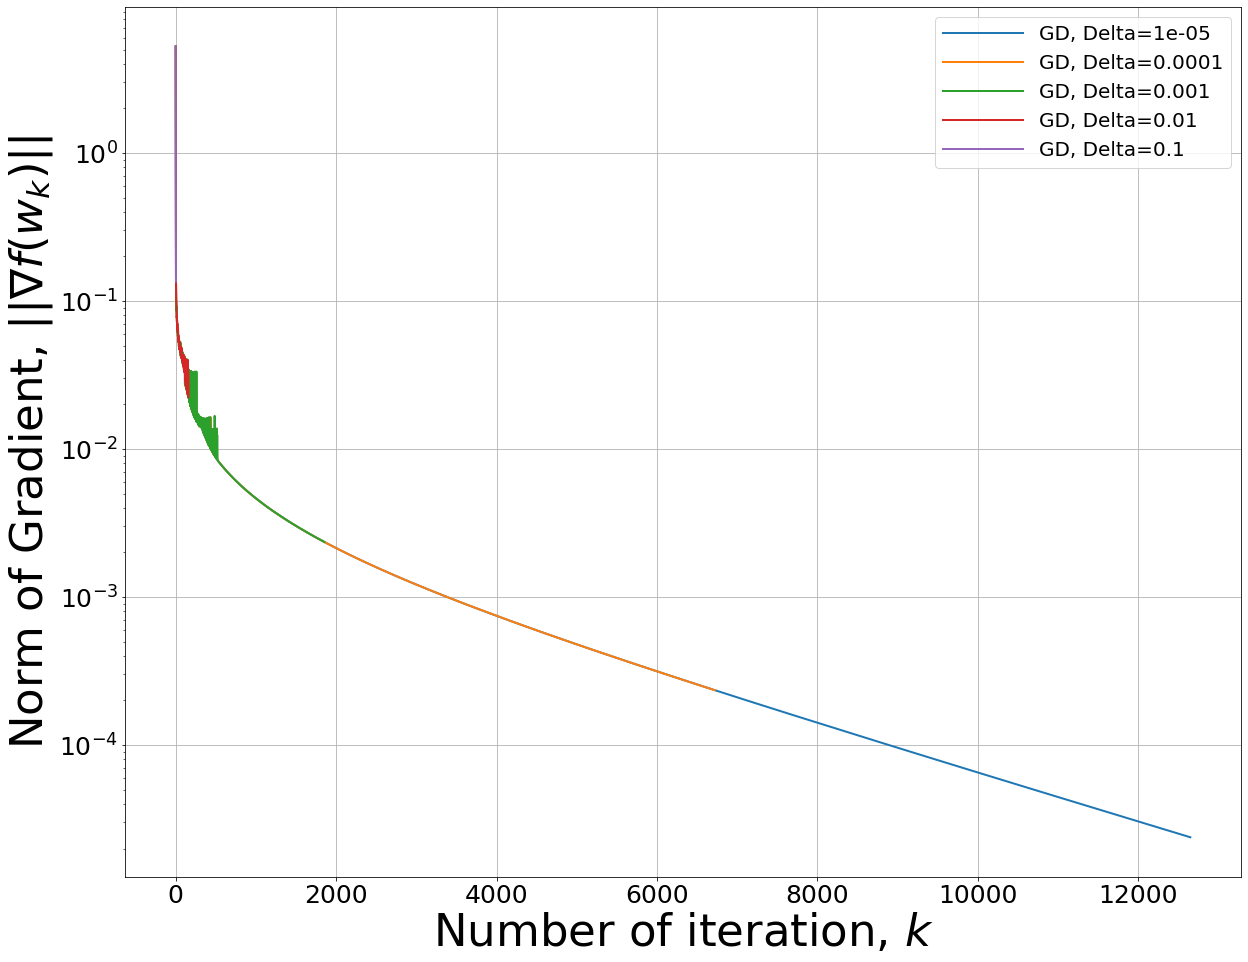

In [17]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(gradf(x))
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.ylabel(r"Norm of Gradient, $||\nabla f(w_k)||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.savefig("pics/grad.png")

In [18]:
np.random.seed(1)
alpha = 1/L
#alpha = 1e-1
w = np.zeros(X.shape[-1])
Delta_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
#Delta_list = [0]
N = int(1e6)
save_iter = int(1)
tol = 1e-9
methods = []
for Delta in Delta_list:
    tol = 0
    grad_inexact = lambda w: gradf_inexact(w, gradf, Delta, 1)
    method = GradientDescent(ConstantStepSize(alpha), name="GD, Delta={}".format(Delta), save_iter=save_iter)
    x = method.solve(w, f, grad_inexact, tol=tol, max_iter=N)
    print(Delta, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history))
    methods.append(method)

1e-05 8.858415330055257e-07 0.0606852418223966 4.402016358726521 1000002
0.0001 7.069567232985972e-06 0.06068524184934541 4.402077168954656 1000002
0.001 5.455491411004086e-05 0.060685243980488246 4.404341349520723 1000002
0.01 0.0005605206399572188 0.060685495033888696 4.681160097197244 1000002
0.1 0.0068558746773211545 0.06071509462547187 16.90965439316933 1000002


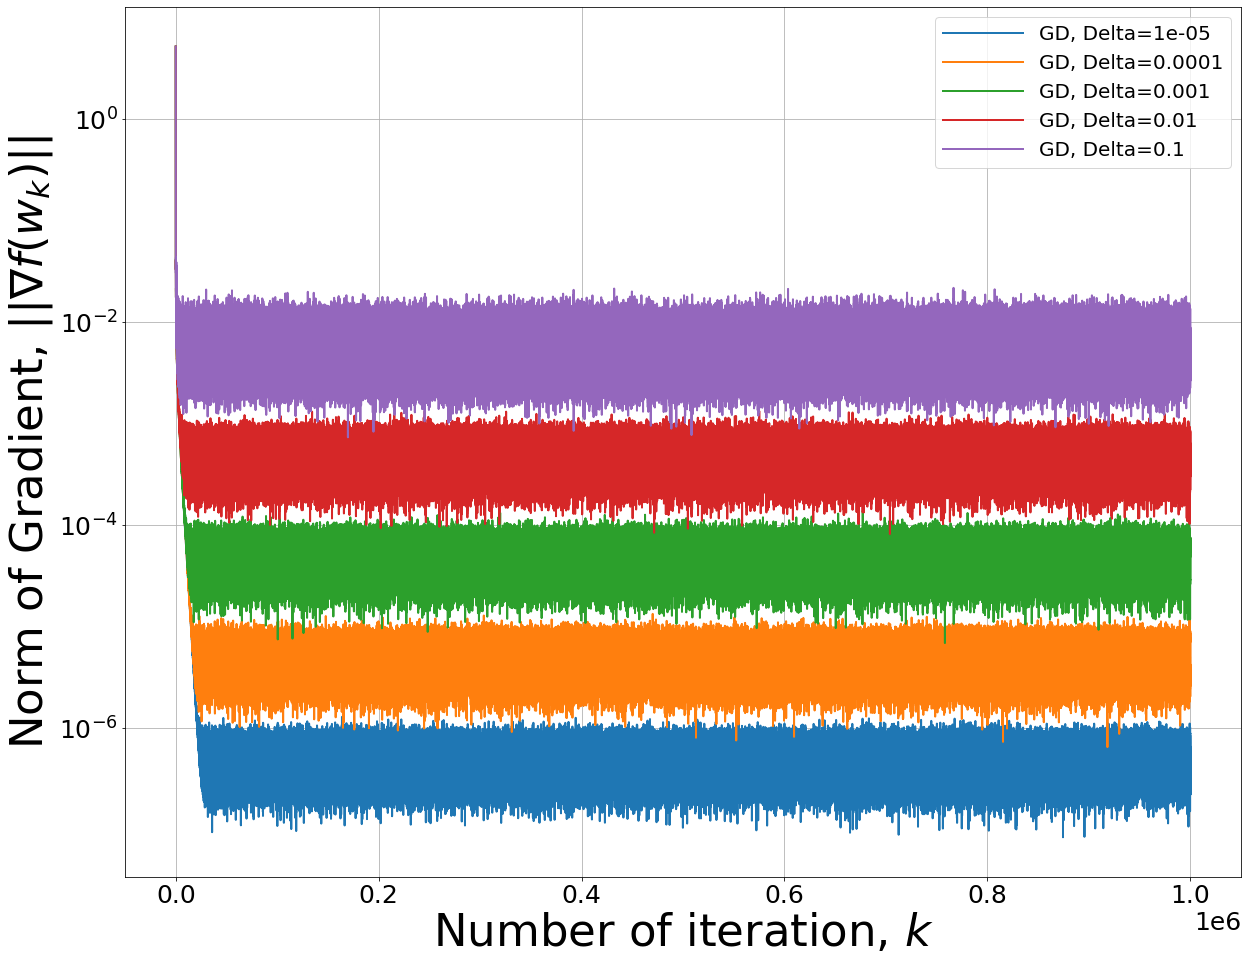

In [19]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(gradf(x))
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.ylabel(r"Norm of Gradient, $||\nabla f(w_k)||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.savefig("pics/grad_non_stop.png")

In [20]:
np.random.seed(1)
alpha = 1/L
#alpha = 1e-1
w = np.zeros(X.shape[-1])
Delta_list = [0, 1e-1]
N = int(2e5)
save_iter = int(1)
tol = 0
methods = []
Delta = 1e-1
for Delta in Delta_list:
    method = GradientDescent(ConstantStepSize(alpha), name="GD, Delta={}".format(Delta), save_iter=save_iter)
    x = method.solve(w, f, lambda w: gradf_inexact(w, gradf, Delta, 1), tol=tol, max_iter=N)
    print(Delta, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history))
    methods.append(method)

0 1.501944076430614e-15 0.060685241822007976 4.402022149391184 200002
0.1 0.004058102322462141 0.06069918532942069 8.455617025954846 200002


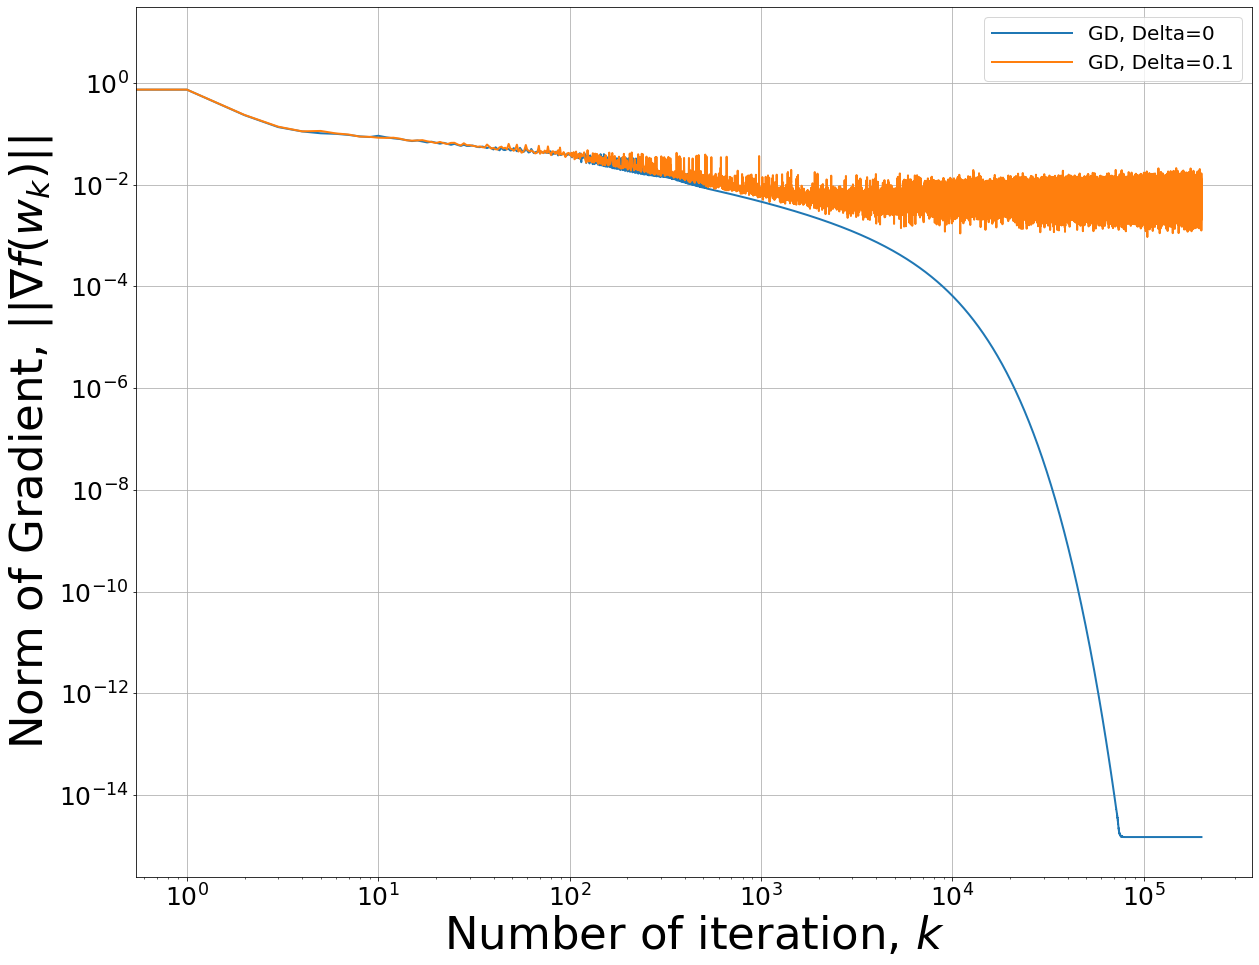

In [21]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(gradf(x))
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.xscale("log")
plt.ylabel(r"Norm of Gradient, $||\nabla f(w_k)||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.savefig("pics/grad_delta.png")

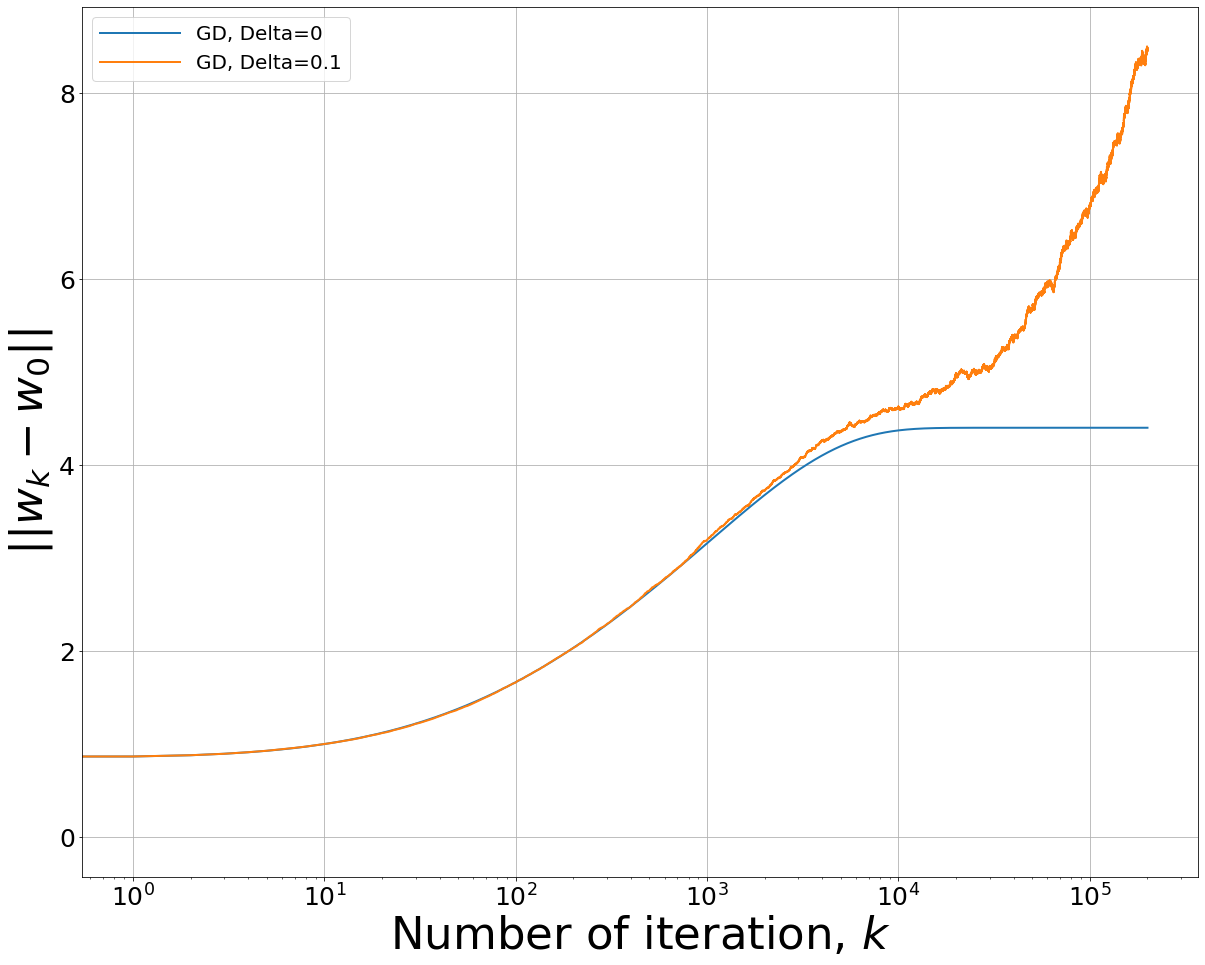

In [22]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(x-w)
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.plot(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.ylabel(r"$||w_k-w_0||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.xscale("log")
plt.savefig("pics/norm_x_delta.png")

### 1.2 Dtype 3

The case when $\xi = -\Delta \nabla f(x)$

In [23]:
np.random.seed(1)
alpha = 1/L
#alpha = 1e-1
w = np.zeros(X.shape[-1])
Delta_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
#Delta_list = [0]
N = int(1e5)
save_iter = int(1)
tol = 1e-9
methods = []
for Delta in Delta_list:
    tol = np.sqrt(6)*Delta
    grad_inexact = lambda w: gradf_inexact(w, gradf, Delta, 3)
    method = GradientDescent(ConstantStepSize(alpha), name="GD, Delta={}".format(Delta), save_iter=save_iter)
    x = method.solve(w, f, grad_inexact, tol=tol, max_iter=N)
    print(Delta, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history))
    methods.append(method)
#001448072963264384

1e-05 3.449298084050813e-05 0.06068550198494167 4.386916350514645 12547
0.0001 0.00034486446355985344 0.06070977503217454 4.257446845441262 6476
0.001 0.003447962211240554 0.06222370796262186 3.3787181576758525 1574
0.01 0.034020723066910584 0.08244472340402308 1.6681292860864207 127
0.1 0.26004101775442495 0.13571144083096714 0.8612402912590174 3


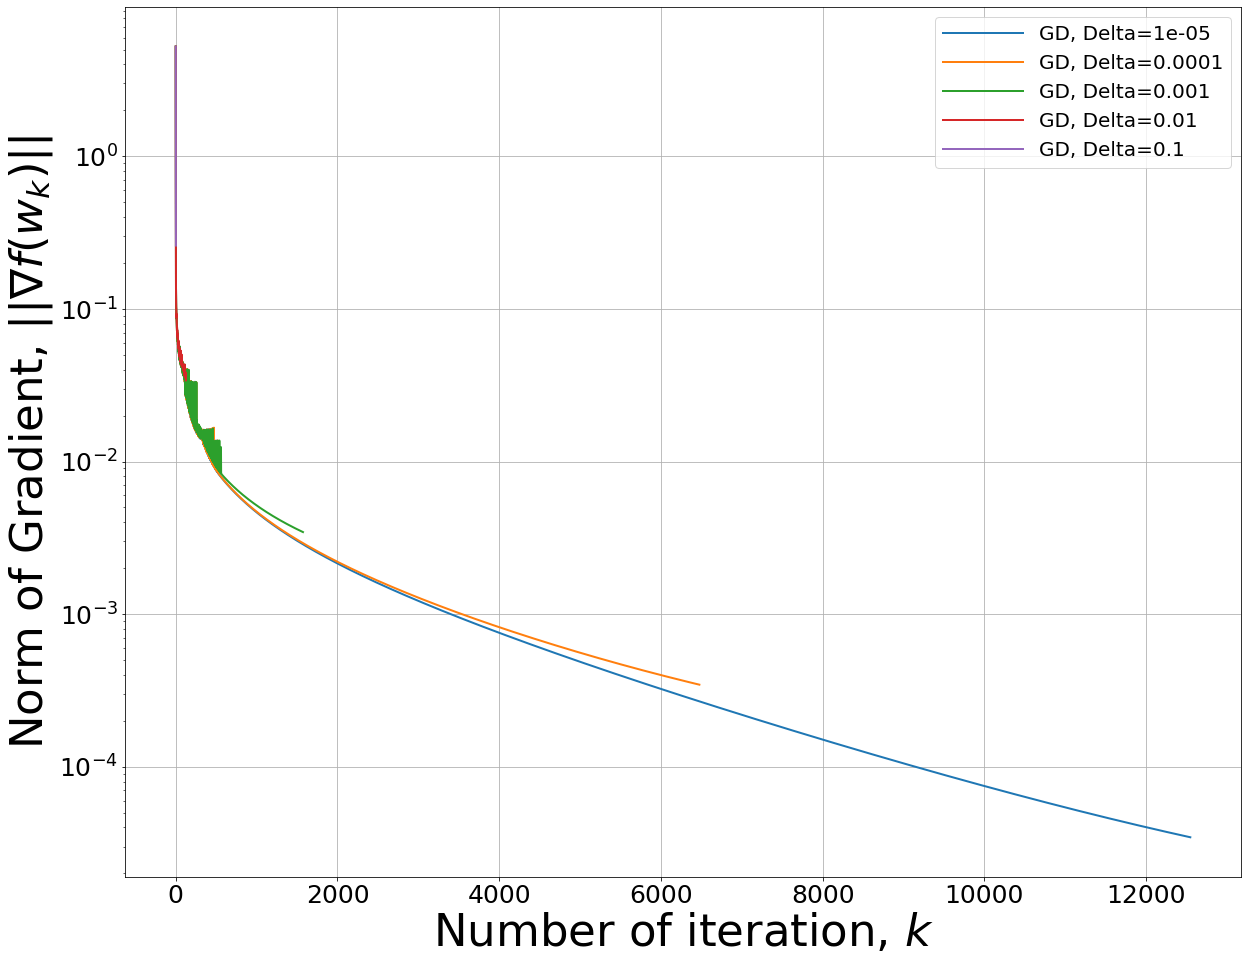

In [24]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(gradf(x))
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.ylabel(r"Norm of Gradient, $||\nabla f(w_k)||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.savefig("pics/grad3.png")

In [25]:
np.random.seed(1)
alpha = 1/L
#alpha = 1e-1
w = np.zeros(X.shape[-1])
Delta_list = [0, 1e-1]
N = int(2e5)
save_iter = int(1)
tol = 0
methods = []
Delta = 1e-1
for Delta in Delta_list:
    method = GradientDescent(ConstantStepSize(alpha), name="GD, Delta={}".format(Delta), save_iter=save_iter)
    x = method.solve(w, f, lambda w: gradf_inexact(w, gradf, Delta, 3), tol=tol, max_iter=N)
    print(Delta, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history))
    methods.append(method)

0 1.501944076430614e-15 0.060685241822007976 4.402022149391184 200002
0.1 0.1 0.12257361113212026 0.9147809497178779 200002


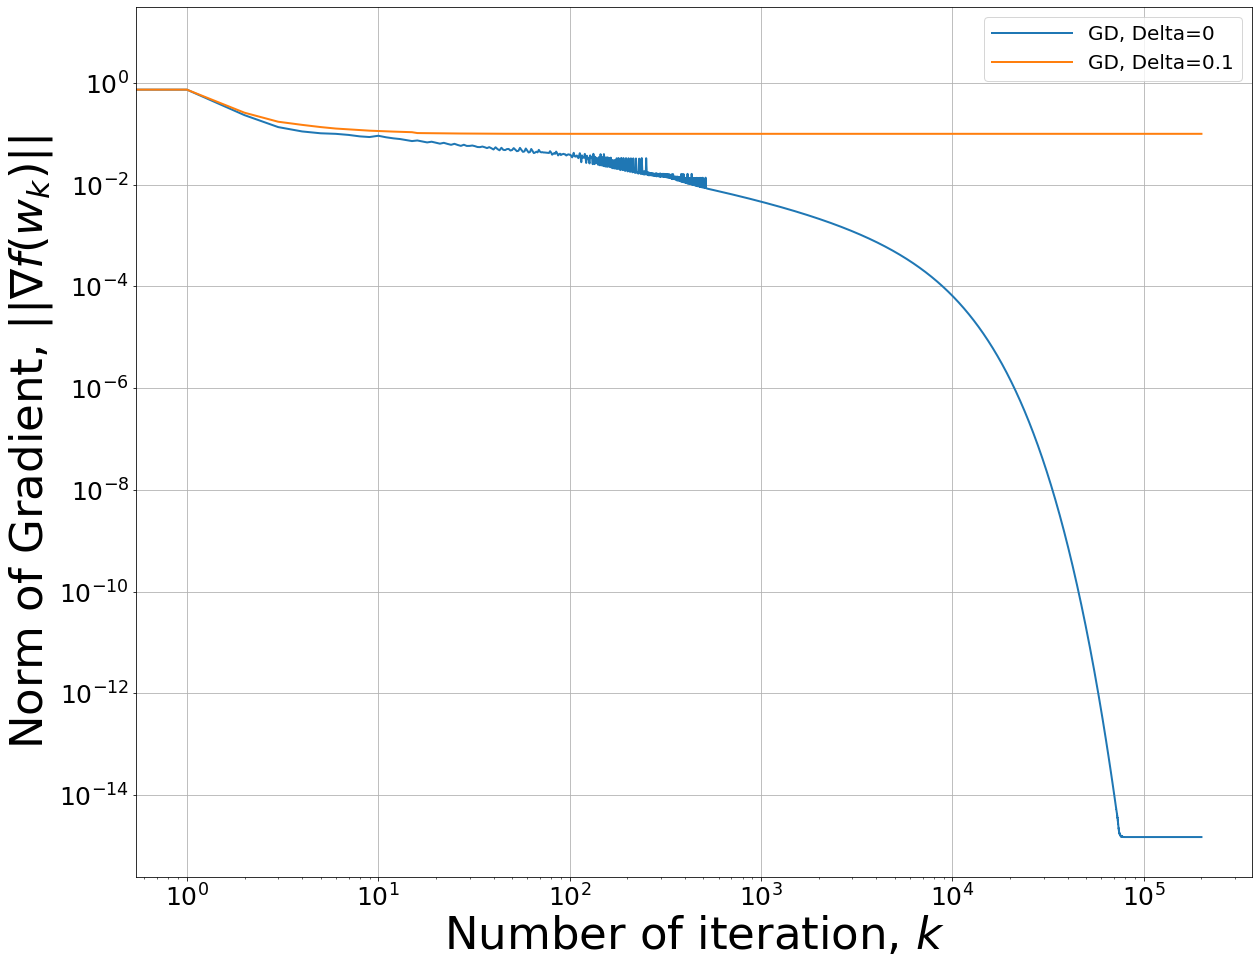

In [26]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(gradf(x))
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.xscale("log")
plt.ylabel(r"Norm of Gradient, $||\nabla f(w_k)||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.savefig("pics/grad3_delta.png")

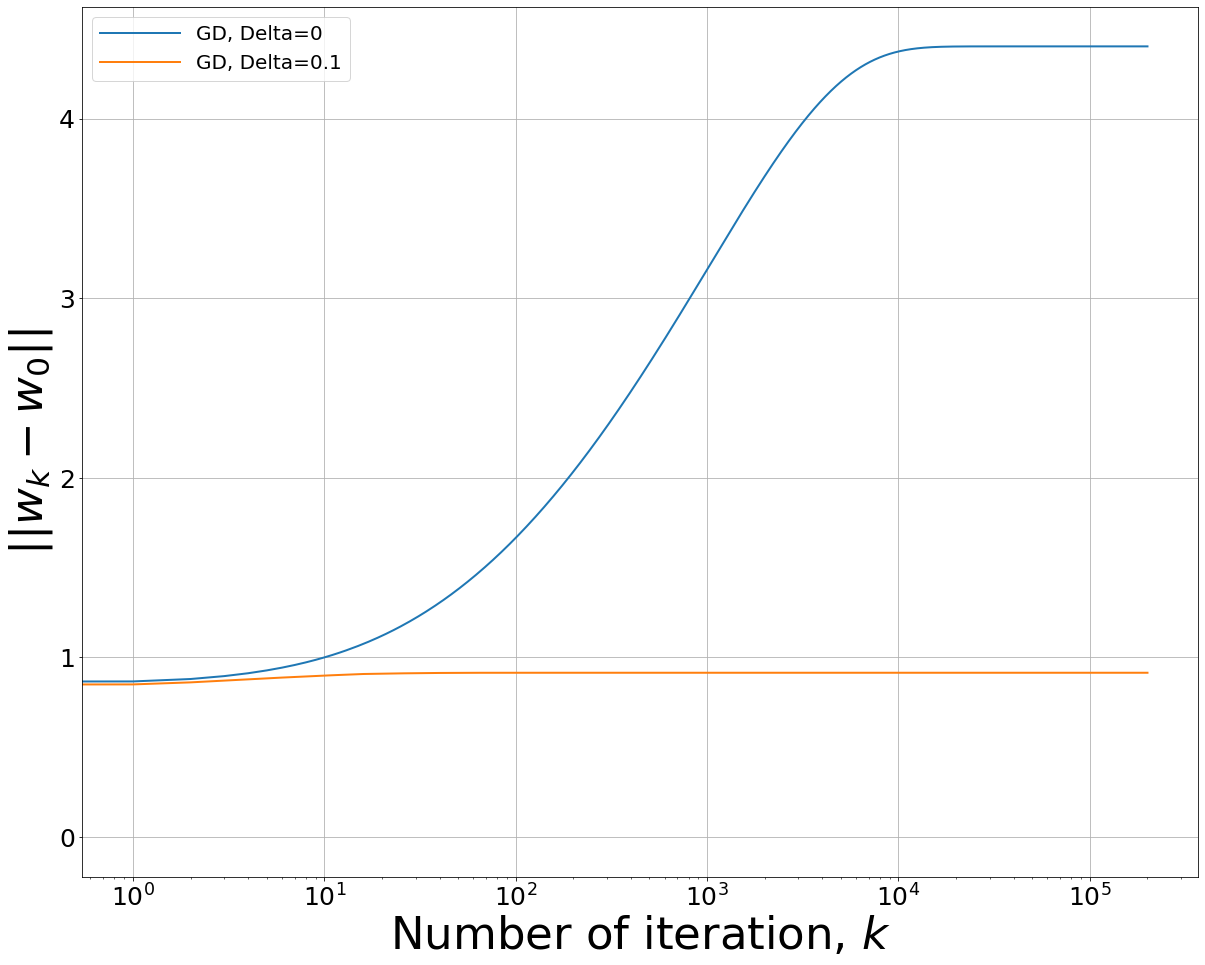

In [27]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(x-w)
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.plot(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.ylabel(r"$||w_k-w_0||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.xscale("log")
plt.savefig("pics/norm_x3_delta.png")

### 1.2 Dtype 4

The case when $\xi = -\Delta v$

In [28]:
np.random.seed(1)
alpha = 1/L
#alpha = 1e-1
w = np.zeros(X.shape[-1])
v = np.random.randn(*w.shape)
Delta_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
#Delta_list = [0]
N = int(1e5)
save_iter = int(1)
tol = 1e-9
methods = []
for Delta in Delta_list:
    tol = np.sqrt(6)*Delta
    grad_inexact = lambda w: gradf_inexact(w, gradf, Delta, 4, v=v)
    method = GradientDescent(ConstantStepSize(alpha), name="GD, Delta={}".format(Delta), save_iter=save_iter)
    x = method.solve(w, f, grad_inexact, tol=tol, max_iter=N)
    print(Delta, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history))
    methods.append(method)
#001448072963264384

1e-05 2.3833622624280936e-05 0.0606853646162968 4.391685736918818 12793
0.0001 0.0002383708959952276 0.06069703846847004 4.302617544302943 6807
0.001 0.0023833824382004038 0.06152179934341419 3.6338475453576438 1890
0.01 0.023611728950613597 0.07737825561526047 1.8880572697556277 156
0.1 0.14154793445713934 0.12617624619995307 0.8928547859149907 4


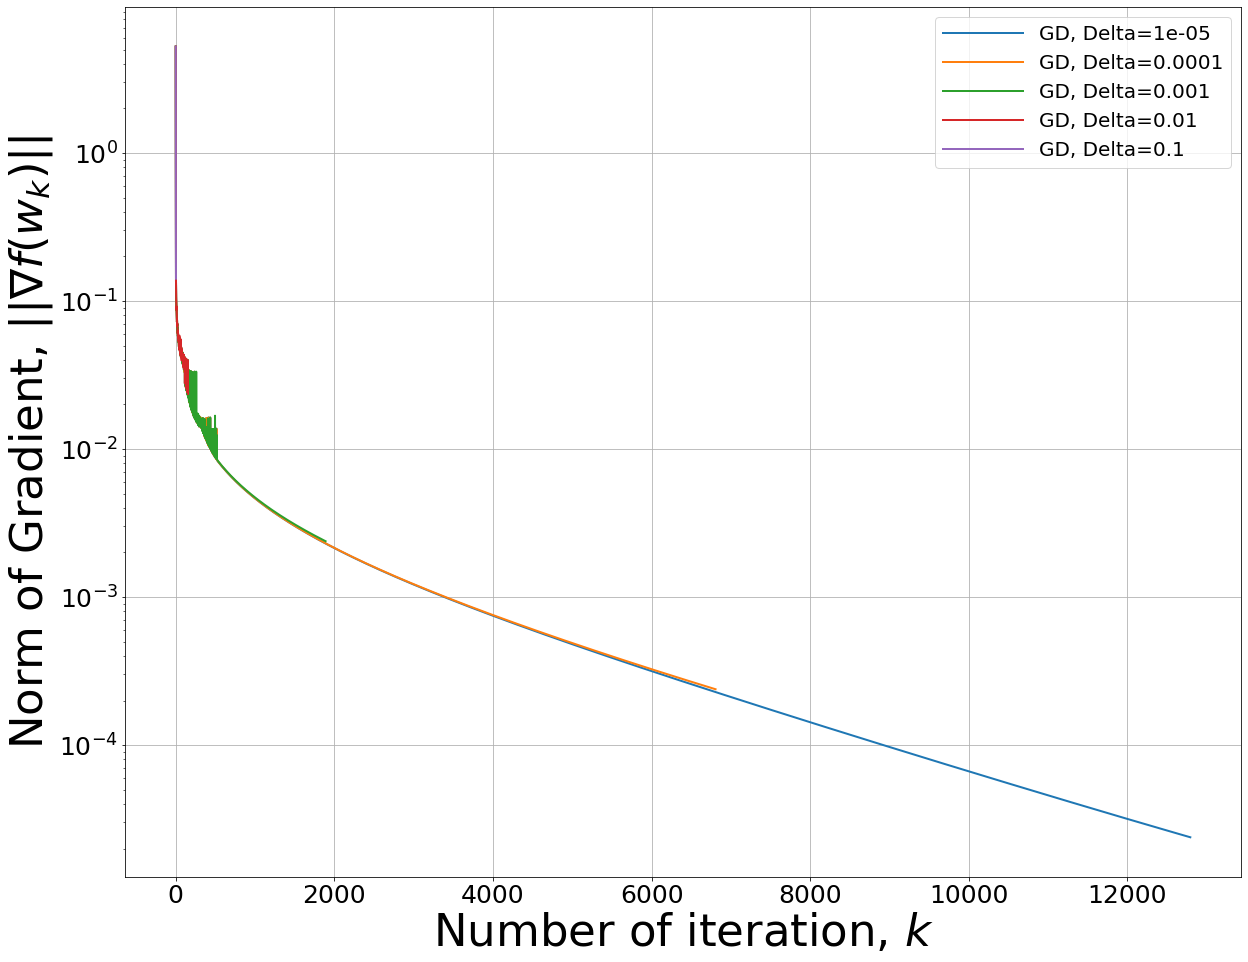

In [29]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(gradf(x))
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.ylabel(r"Norm of Gradient, $||\nabla f(w_k)||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.savefig("pics/grad4.png")

In [30]:
np.random.seed(1)
alpha = 1/L
#alpha = 1e-1
w = np.zeros(X.shape[-1])
Delta_list = [0, 1e-1]
N = int(2e5)
save_iter = int(1)
tol = 0
methods = []
Delta = 1e-1
for Delta in Delta_list:
    method = GradientDescent(ConstantStepSize(alpha), name="GD, Delta={}".format(Delta), save_iter=save_iter)
    x = method.solve(w, f, lambda w: gradf_inexact(w, gradf, Delta, 4, v=v), tol=tol, max_iter=N)
    print(Delta, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history))
    methods.append(method)

0 1.501944076430614e-15 0.060685241822007976 4.402022149391184 200002
0.1 0.028327580141101785 0.06853051294924589 3158.252371053971 200002


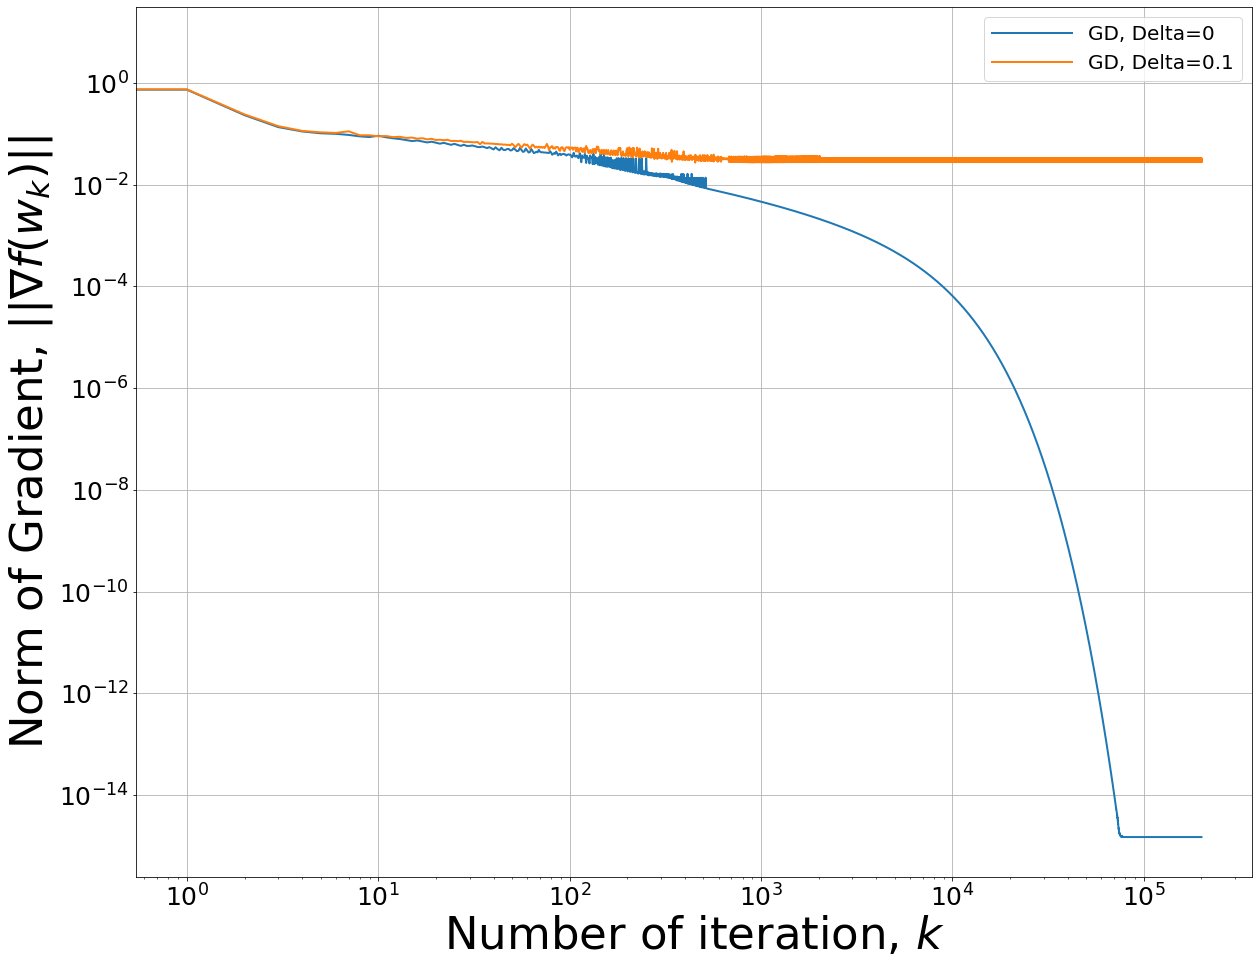

In [31]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(gradf(x))
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.xscale("log")
plt.ylabel(r"Norm of Gradient, $||\nabla f(w_k)||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.savefig("pics/grad4_delta.png")

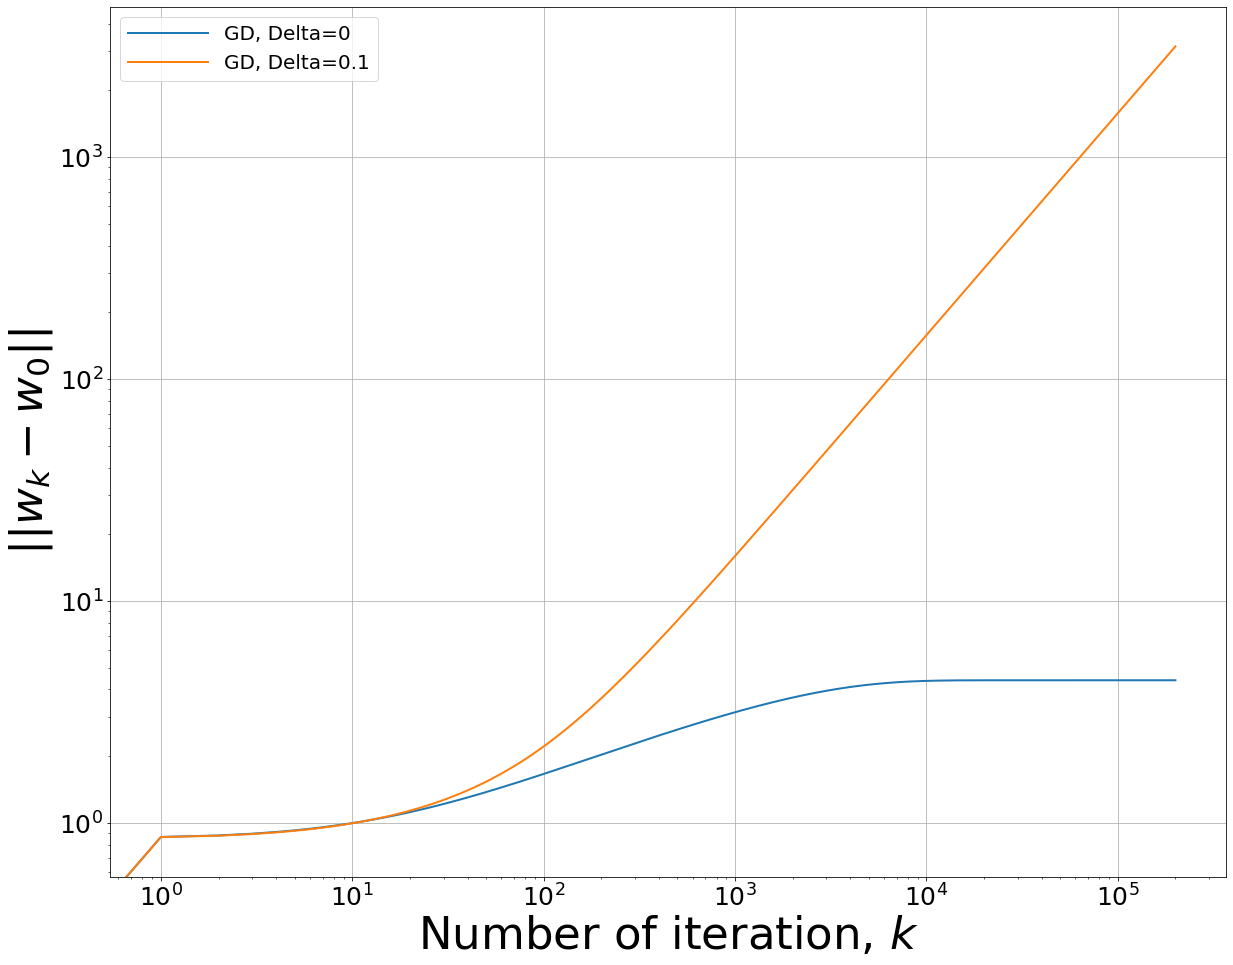

In [32]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(x-w)
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.ylabel(r"$||w_k-w_0||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.xscale("log")
plt.savefig("pics/norm_x4_delta.png")

## 2. MSE minimization

In [47]:
def f1(x, A):
    m = A.shape[0]
    r = A@x
    return 1/2 * x.T @ A @ x

gradf = jax.grad(f1, argnums=0, has_aux=False)
jit_gradf = jax.jit(gradf)

In [48]:
np.random.seed(1)
n = 100
k = 10
mu = 0.1
d = np.zeros(n)
d[:k] *= 0
d[k:] = np.linspace(mu, 1, n-k)
A = np.diag(d)
w = np.random.randn(n)
A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.97977528, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.98988764,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [49]:
eigvals, _ = np.linalg.eigh(A)
eigvals.sort()
L = np.real(eigvals.max())
mu = eigvals[eigvals>=1e-12].min()
L, mu

(1.0, 0.1)

In [50]:
sigma=0
gradf = lambda x: np.array(jit_gradf(x, A).block_until_ready())
f = lambda x: f1(x, A)

In [51]:
w = np.random.randn(n)
f(np.zeros(A.shape[-1]))

0.0

The case when $\xi \sim \mathcal{U}(S_1(0))$

In [58]:
np.random.seed(1)
np.random.seed(1)
n = 100
k = 10
mu_list = [0.01, 0.1, 0.9, 0.99]
res = {mu:{"delta":[], "iters":[], "N":[]} for mu in mu_list}
for mu in mu_list:
    d = np.zeros(n)
    d[:k] *= 0
    d[k:] = np.linspace(mu, 1, n-k)
    A = np.diag(d)
    w = np.random.randn(n)
    sigma=0
    eigvals, _ = np.linalg.eigh(A)
    eigvals.sort()
    L = np.real(eigvals.max())
    mu = eigvals[eigvals>=1e-12].min()
    L, mu
    print(mu)
    gradf = lambda x: np.array(jit_gradf(x, A).block_until_ready())
    f = lambda x: f1(x, A)
    f(np.zeros(A.shape[-1]))
    alpha = 1/L
    w = np.ones(n)*100
    v = np.random.randn(*w.shape)
    Delta_list = [1e-7, 1e-4, 1e-1]
    N = int(2e4)
    save_iter = int(1)
    tol = 1e-9
    methods = []
    for Delta in Delta_list:
        tol = np.sqrt(6)*Delta
        if Delta > 0:
            N_star = int(L/mu * np.log(mu*f(w)/(6*Delta**2)) + 0.5)
        else:
            N_star = np.inf
        grad_inexact = lambda w: gradf_inexact(w, gradf, Delta, 1, v=v)
        method = GradientDescent(ConstantStepSize(alpha), name="GD, Delta={}".format(Delta), save_iter=save_iter)
        x = method.solve(w, f, grad_inexact, tol=tol, max_iter=N)
        print("\t{}\t{}\t{}\t{:.2f}".format(Delta, len(method.history), N_star, N_star/len(method.history)))
        methods.append(method)
        res[mu]["delta"].append(int(np.log10(Delta)))
        res[mu]["iters"].append(len(method.history))
        res[mu]["N"].append(N_star)

0.01
	1e-07	1528	3817	2.50
	0.0001	841	2436	2.90
	0.1	155	1054	6.80
0.1
	1e-07	169	406	2.40
	0.0001	104	267	2.57
	0.1	40	129	3.23
0.9
	1e-07	10	48	4.80
	0.0001	8	33	4.12
	0.1	5	17	3.40
0.99
	1e-07	6	44	7.33
	0.0001	5	30	6.00
	0.1	3	16	5.33


In [88]:
s = ""
for mu in mu_list:
    s += str(mu) + " & "
    cur_list = ["$10^{{{}}}$".format(i) for i in res[mu]["delta"]]
    s+= "\\begin{tabular}{@{}c@{}} " + " \\\\ ".join(cur_list) + " \\end{tabular}&"
    cur_list = ["${}$".format(i) for i in res[mu]["iters"]]
    s+= "\\begin{tabular}{@{}c@{}} " + " \\\\ ".join(cur_list) + " \\end{tabular}&"
    cur_list = ["${}$".format(i) for i in res[mu]["N"]]
    s+= "\\begin{tabular}{@{}c@{}} " + " \\\\ ".join(cur_list) + " \\end{tabular}"
    s+= "\\\\\n\\hline\n"
print(s)

0.01 & \begin{tabular}{@{}c@{}} $10^{-7}$ \\ $10^{-4}$ \\ $10^{-1}$ \end{tabular}&\begin{tabular}{@{}c@{}} $1528$ \\ $841$ \\ $155$ \end{tabular}&\begin{tabular}{@{}c@{}} $3817$ \\ $2436$ \\ $1054$ \end{tabular}\\
\hline
0.1 & \begin{tabular}{@{}c@{}} $10^{-7}$ \\ $10^{-4}$ \\ $10^{-1}$ \end{tabular}&\begin{tabular}{@{}c@{}} $169$ \\ $104$ \\ $40$ \end{tabular}&\begin{tabular}{@{}c@{}} $406$ \\ $267$ \\ $129$ \end{tabular}\\
\hline
0.9 & \begin{tabular}{@{}c@{}} $10^{-7}$ \\ $10^{-4}$ \\ $10^{-1}$ \end{tabular}&\begin{tabular}{@{}c@{}} $10$ \\ $8$ \\ $5$ \end{tabular}&\begin{tabular}{@{}c@{}} $48$ \\ $33$ \\ $17$ \end{tabular}\\
\hline
0.99 & \begin{tabular}{@{}c@{}} $10^{-7}$ \\ $10^{-4}$ \\ $10^{-1}$ \end{tabular}&\begin{tabular}{@{}c@{}} $6$ \\ $5$ \\ $3$ \end{tabular}&\begin{tabular}{@{}c@{}} $44$ \\ $30$ \\ $16$ \end{tabular}\\
\hline



## 2. MSE minimization:visual

In [39]:
def f1(x, A):
    m = A.shape[0]
    r = A@x
    return 1/2 * x.T @ A @ x

gradf = jax.grad(f1, argnums=0, has_aux=False)
jit_gradf = jax.jit(gradf)

In [40]:
np.random.seed(1)
n = 2
k = 1
d = np.random.rand(n)
d.sort()
d[:k] *= 0
A = np.diag(d)
w = np.random.randn(n)
A

array([[0.        , 0.        ],
       [0.        , 0.72032449]])

In [41]:
eigvals, _ = np.linalg.eigh(A)
eigvals.sort()
L = np.real(eigvals.max())
mu = eigvals[eigvals>=1e-12].min()
L, np.linalg.norm(w), mu

(0.7203244934421581, 1.1959210107782037, 0.7203244934421581)

In [42]:
sigma=0
gradf = lambda x: np.array(jit_gradf(x, A).block_until_ready())
f = lambda x: f1(x, A)

In [43]:
w = np.random.randn(n)
f(np.zeros(A.shape[-1]))

0.0

The case when $\xi \sim \mathcal{U}(S_1(0))$

In [44]:
def gradf_inexact(w, gradf, Delta=0, dtype=1, v=None):
    n = len(w)
    g = gradf(w)
    xi = np.random.normal(0, 1, (n,))
    if dtype==1:
        xi /= np.linalg.norm(xi)
    elif dtype==2:
        xi /= n
    elif dtype == 3:
        xi = -g.copy()
        xi /= np.linalg.norm(xi)
    elif dtype == 4:
        xi = v / np.linalg.norm(v)
    assert np.linalg.norm(xi)<=1+1e-9, "xi has no 1 norm"
    return g + Delta * xi

In [45]:
np.random.seed(1)
alpha = 1/L
#alpha = 1e-1
w = np.ones(n)
v = np.ones(n)
Delta_list = [0, 1e-1]
N = int(500)
save_iter = int(1)
tol = 0
methods = []
Delta = 1e-1

Delta = 0
tol = np.sqrt(6)*Delta
method = GradientDescent(ConstantStepSize(alpha), name="Exact", save_iter=save_iter)
x = method.solve(w, f, lambda w: gradf_inexact(w, gradf, Delta, 4, v=v), tol=tol, max_iter=N)
print(Delta, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history))
methods.append(method)
Delta = 1e-1
grad_name = {1:"random inexactness",3:"-gradient",4:"constant inexactness",}
for dtype in [1,3,4]:
    tol = np.sqrt(6)*Delta
    method = GradientDescent(ConstantStepSize(alpha), name="{}".format(grad_name[dtype]), save_iter=save_iter)
    x = method.solve(w, f, lambda w: gradf_inexact(w, gradf, Delta, dtype, v=v), tol=tol, max_iter=N)
    print(dtype, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history))
    methods.append(method)

0 0.0 0.0 1.0 12
1 0.09968341458998949 0.0068974352772842714 0.9985974442997492 2
3 0.10000000000000002 0.006941316095065565 1.009590386073801 2
4 0.07071067811865461 0.003470658047532768 0.9071618821387056 2


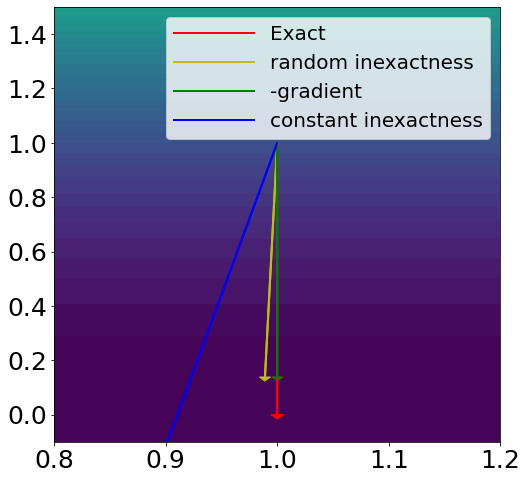

In [46]:
l = 100
x, y = np.mgrid[-l:l,
                -l:l]
x = x / 50
y = y/50
z = np.zeros((2*l, 2*l))
for i in range(2*100):
    for j in range(2*100):
        z[i, j] = f(np.array([x[i, j], y[i, j]]))
#z = np.log(z+1e-16)+16
fig, ax = plt.subplots()
ax.contourf(x, y, z, levels=50)


color = ["r", "y", "green", "b"]
for indm, method in enumerate(methods):
    xhistory = method.history
    x_list = np.array([x for x, _ in xhistory])
    plt.plot(x_list[:, 0], x_list[:, 1], color=color[indm], label=method.name)
    for ind in range(len(x_list)-1):
        x, y = x_list[ind, 0], x_list[ind,1]
        dx, dy = x_list[ind+1, 0] - x_list[ind, 0], x_list[ind+1,1] - x_list[ind,1]
        if ind % 1 == 0:
            head_width=0.01
        else:
            head_width=0
        ax.arrow(x, y, dx, dy, color=color[indm], head_width=head_width)
plt.legend()
fig.set_figwidth(8)    #  ширина и
fig.set_figheight(8)    #  высота "Figure"

plt.xlim(.8, 1.2)
plt.ylim(-0.1, 1.5)
plt.savefig("pics/lines.png")